In [1]:
import numpy as np
import cv2
from sklearn.preprocessing import MinMaxScaler
from skimage.feature import greycomatrix, greycoprops
from skimage import io
import pandas as pd
from os import listdir
from os.path import join
import matplotlib.pyplot as plt

In [2]:
def GLCM(gray, props):
    data = []
    
    glcm = greycomatrix(gray,
                        distances=[2],
                        angles=[np.pi / 4],
                        levels=256,
                        symmetric=True,
                        normed=True)

    for prop in props:
        value = greycoprops(glcm, prop)
        data.append(value[0][0])
    
    return data

In [3]:
props = [
    'contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM'
]

nomal_fld = './data1/nomal_data/nomal'
anomal_fld = './data1/anomal_data/anomal'
# nomal_fld = './test/nomal'
# anomal_fld = './test/anomal'
nomal_fs = listdir(nomal_fld)
anomal_fs = listdir(anomal_fld)
nomal_data = []
anomal_data = []

# extract feature
for nf, af in zip(nomal_fs, anomal_fs):
    n_img = io.imread(join(nomal_fld, nf))
    a_img = io.imread(join(anomal_fld, af))

    nomal_feature = GLCM(n_img, props)
    anomal_feature = GLCM(a_img, props)

    nomal_data.append(nomal_feature)
    anomal_data.append(anomal_feature)

# build dataframe
nomal_df = pd.DataFrame(nomal_data, columns=props)
anomal_df = pd.DataFrame(anomal_data, columns=props)

nomal_df['nomal'] = 1
anomal_df['nomal'] = 0
df = pd.concat([nomal_df, anomal_df], ignore_index=True)

df.to_csv('./feature_data/feature.csv', index=False)

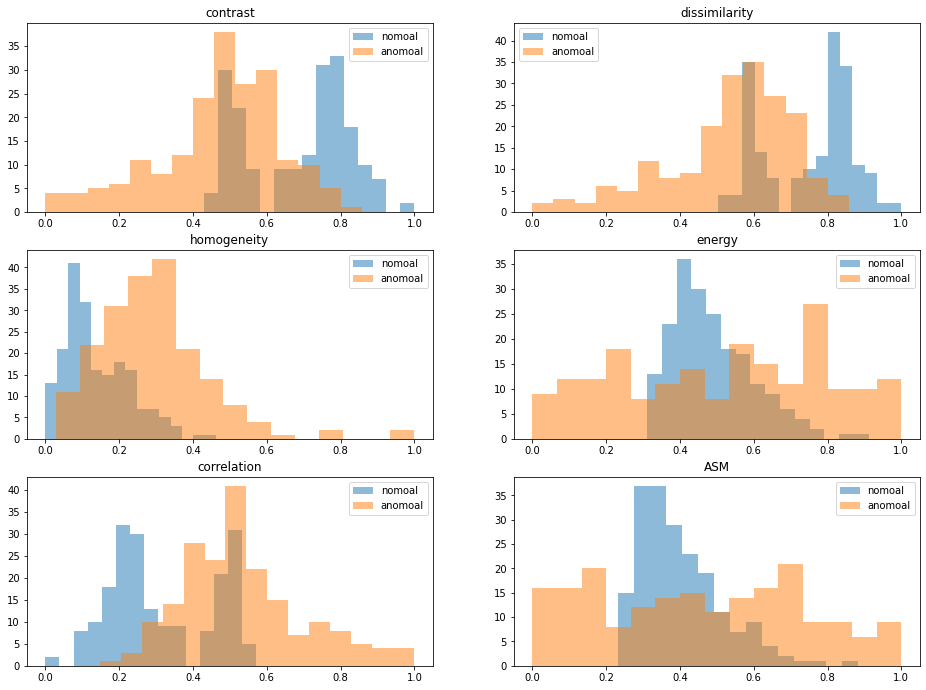

In [4]:
df = pd.read_csv('./feature_data/feature.csv')

# normalize data
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)


# split nomal and anomal
nomal_df = df[df['nomal'] == 1]
anomal_df = df[df['nomal'] == 0]

plt.figure(figsize=(16, 16))
for i, prop in enumerate(props):
    plt.subplot(4, 2, i+1)
    plt.title(prop)
    plt.hist(nomal_df[prop], 15, histtype='bar', label='nomoal',alpha=0.5)
    plt.hist(anomal_df[prop], 15, histtype='bar', label='anomoal',alpha=0.5)
    plt.legend()